In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

#my imports
import env
import os
import wrangle as w
import explore as e
import model as m

In [4]:
#Get my data
df = w.acquire_zillow()

In [5]:
df = w.prepare_zillow(df)

In [6]:
df = e.create_features(df)

In [7]:
df = e.get_counties(df)

In [8]:
train, validate, test = w.train_validate_test_split(df)

In [9]:
#Make bins for log error
train['logerror_bins'] = pd.cut(train.log_error, [-5, -.2, -.05, .05, .2, 4])

In [8]:
train.head()

,parcel_id,propertylandusetypeid,basement_sqft,bath_count,bed_count,calc_bath_and_bed,decktypeid,calc_sqft,finished_sqft12,fips,...,structure_dollar_per_sqft,structure_dollar_sqft_bin,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola,LA,Orange,Ventura,logerror_bins
38935,14392368,261.0,0.0,2.5,4.0,2.5,0.0,2832.0,2832.0,6059.0,...,130.530014,0.4,35.481693,0.3,0.625000,0,0,1,0,"(-0.05, 0.05]"
31408,14368210,261.0,0.0,2.5,4.0,2.5,0.0,2255.0,2255.0,6059.0,...,75.004435,0.3,19.219286,0.2,0.625000,0,0,1,0,"(0.05, 0.2]"
30966,11300975,261.0,0.0,3.0,3.0,3.0,0.0,1563.0,1563.0,6037.0,...,58.162508,0.2,3.176240,0.1,1.000000,0,1,0,0,"(0.05, 0.2]"
5412,13926000,261.0,0.0,2.0,3.0,2.0,0.0,1447.0,1447.0,6059.0,...,32.089150,0.1,4.071429,0.1,0.666667,0,0,1,0,"(0.05, 0.2]"
45802,17229160,261.0,0.0,2.5,3.0,2.5,0.0,1415.0,1415.0,6111.0,...,128.823322,0.4,22.875767,0.3,0.833333,0,0,0,1,"(-0.2, -0.05]"


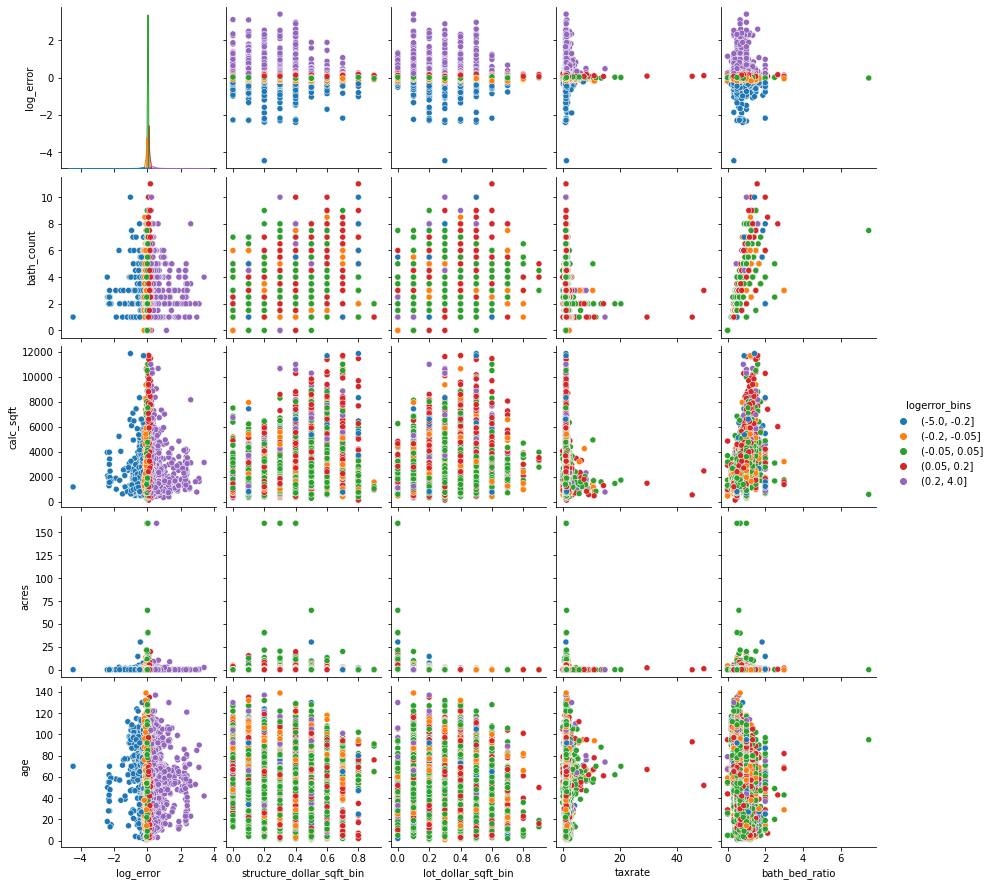

In [17]:
#Pairplot for log error bins
sns.pairplot(data = train, hue = 'logerror_bins', 
             x_vars = ['log_error', 'structure_dollar_sqft_bin', 'lot_dollar_sqft_bin', 'taxrate', 
                       'bath_bed_ratio'],
             y_vars = ['log_error', 'bath_count', 'calc_sqft', 'acres', 'age'])

In [ ]:
train.head().T

In [ ]:
#Ensuring no nulls are present
train.isna().sum().sum()

In [9]:
#Scaling variables
def scale_data(train, 
               validate, 
               test, 
               columns_to_scale=['latitude', 'longitude', 'age'],return_scaler=False):
    '''This function takes in train, validate, test, and outputs scaled data based on
    the chosen method (quantile scaling) using the columns selected as the only columns
    that will be scaled. This function also returns the scaler object as an array if set 
    to true'''
    # make copies of our original data
    train_scaled = train.copy()
    validate_scaled = validate.copy()
    test_scaled = test.copy()
     # select a scaler
    scaler = MinMaxScaler()
     # fit on train
    scaler.fit(train[columns_to_scale])
    # applying the scaler:
    train_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(train[columns_to_scale]),
                                                  columns=train[columns_to_scale].columns.values).set_index([train.index.values])
                                                  
    validate_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(validate[columns_to_scale]),
                                                  columns=validate[columns_to_scale].columns.values).set_index([validate.index.values])
    
    test_scaled[columns_to_scale] = pd.DataFrame(scaler.transform(test[columns_to_scale]),
                                                 columns=test[columns_to_scale].columns.values).set_index([test.index.values])
    if return_scaler:
        return scaler, train_scaled, validate_scaled, test_scaled
    else:
        return train_scaled, validate_scaled, test_scaled

In [10]:
train_scaled, validate_scaled, test_scaled = scale_data(train, validate, test, 
                                                        columns_to_scale =
                                                       ['latitude','longitude','age','bath_bed_ratio', 'calc_sqft',
                                                       'taxrate','structure_dollar_per_sqft','tax_value'])

In [11]:
#Building a set for a location cluster
location = train_scaled[['latitude','longitude','age']]

In [13]:
#Fit and predict location
kmeans = KMeans(n_clusters=4)
kmeans.fit(location)
kmeans.predict(location)

array([2, 2, 1, ..., 2, 3, 2], dtype=int32)

In [14]:
train_scaled['location_cluster'] = kmeans.predict(location)

In [15]:
kmeans.cluster_centers_

array([[0.4521325 , 0.66877159, 0.52173276],
       [0.84499948, 0.68933225, 0.21091744],
       [0.28562283, 0.849552  , 0.28285273],
       [0.60564377, 0.39205635, 0.32643501]])

In [16]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=location.columns)
centroids

,latitude,longitude,age
0,0.452132,0.668772,0.521733
1,0.844999,0.689332,0.210917
2,0.285623,0.849552,0.282853
3,0.605644,0.392056,0.326435


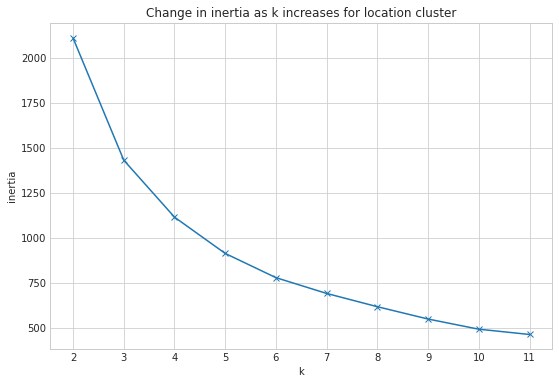

In [29]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(location).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for location cluster')

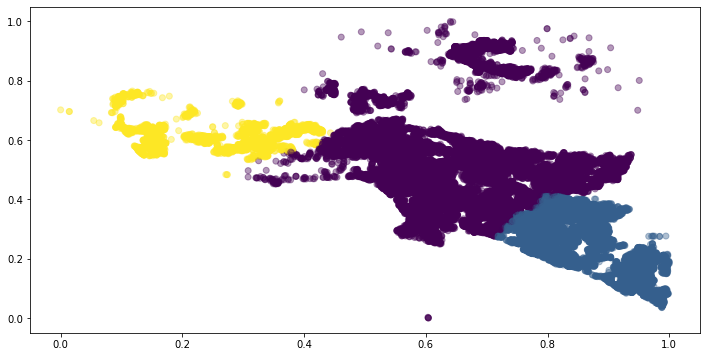

In [29]:
plt.figure(figsize=(12,6))
plt.scatter(y=train_scaled.latitude, x=train_scaled.longitude, c=train_scaled.fips, alpha=.4)

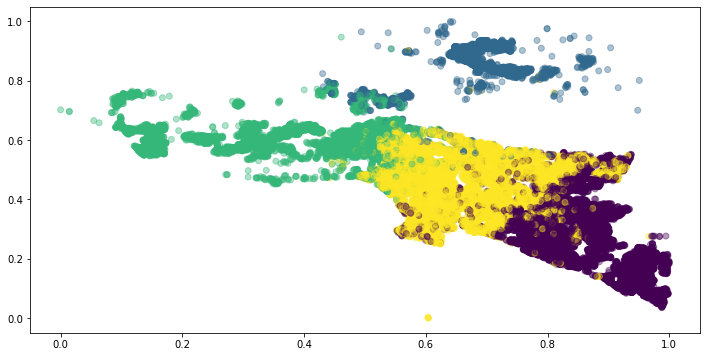

In [32]:
plt.figure(figsize=(12,6))
plt.scatter(y=train_scaled.latitude, x=train_scaled.longitude, c=train_scaled.location_cluster, alpha=.4)
#plt.scatter(y=train_scaled.age, x=train_scaled.longitude, c=train_scaled.location_cluster, alpha=.4)
#plt.scatter(y=train_scaled.age, x=train_scaled.latitude, c=train_scaled.location_cluster, alpha=.4)

Text(0.5, 1.0, 'Do clusters reveal differences in age and error?')

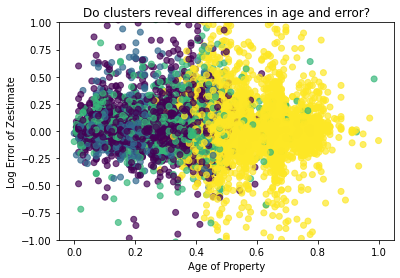

In [33]:
plt.scatter(y=train_scaled.log_error, x=train_scaled.age, c=train_scaled.location_cluster, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('Age of Property')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in age and error?")

In [17]:
#Making a size cluster
size = train_scaled[['bath_bed_ratio','calc_sqft']]
size.head()

,bath_bed_ratio,calc_sqft
38935,0.083333,0.228513
31408,0.083333,0.179314
30966,0.133333,0.120310
5412,0.088889,0.110420
45802,0.111111,0.107691


In [18]:
#Fit and predict
kmeans = KMeans(n_clusters=4)
kmeans.fit(size)
kmeans.predict(size)

array([0, 3, 3, ..., 1, 0, 3], dtype=int32)

In [19]:
#Put it back into train scaled
train_scaled['size_cluster'] = kmeans.predict(size)

In [21]:
train_scaled.head()

,parcel_id,propertylandusetypeid,basement_sqft,bath_count,bed_count,calc_bath_and_bed,decktypeid,calc_sqft,finished_sqft12,fips,...,land_dollar_per_sqft,lot_dollar_sqft_bin,bath_bed_ratio,cola,LA,Orange,Ventura,logerror_bins,location_cluster,size_cluster
38935,14392368,261.0,0.0,2.5,4.0,2.5,0.0,0.228513,2832.0,6059.0,...,35.481693,0.3,0.083333,0,0,1,0,"(-0.05, 0.05]",1,3
31408,14368210,261.0,0.0,2.5,4.0,2.5,0.0,0.179314,2255.0,6059.0,...,19.219286,0.2,0.083333,0,0,1,0,"(0.05, 0.2]",1,0
30966,11300975,261.0,0.0,3.0,3.0,3.0,0.0,0.120310,1563.0,6037.0,...,3.176240,0.1,0.133333,0,1,0,0,"(0.05, 0.2]",3,0
5412,13926000,261.0,0.0,2.0,3.0,2.0,0.0,0.110420,1447.0,6059.0,...,4.071429,0.1,0.088889,0,0,1,0,"(0.05, 0.2]",1,2
45802,17229160,261.0,0.0,2.5,3.0,2.5,0.0,0.107691,1415.0,6111.0,...,22.875767,0.3,0.111111,0,0,0,1,"(-0.2, -0.05]",0,2


In [20]:
#cluster centers
kmeans.cluster_centers_
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=size.columns)
centroids

,bath_bed_ratio,calc_sqft
0,0.116828,0.268092
1,0.078669,0.093975
2,0.151386,0.489636
3,0.100228,0.162807


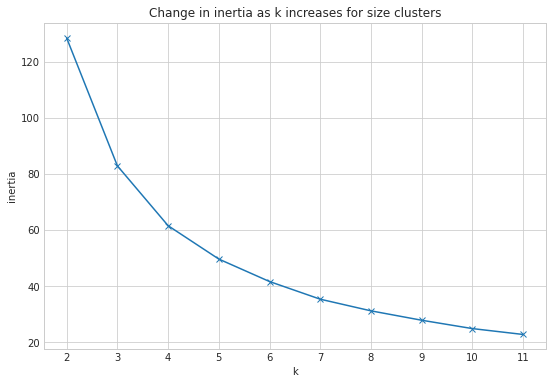

In [39]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(size).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for size clusters')

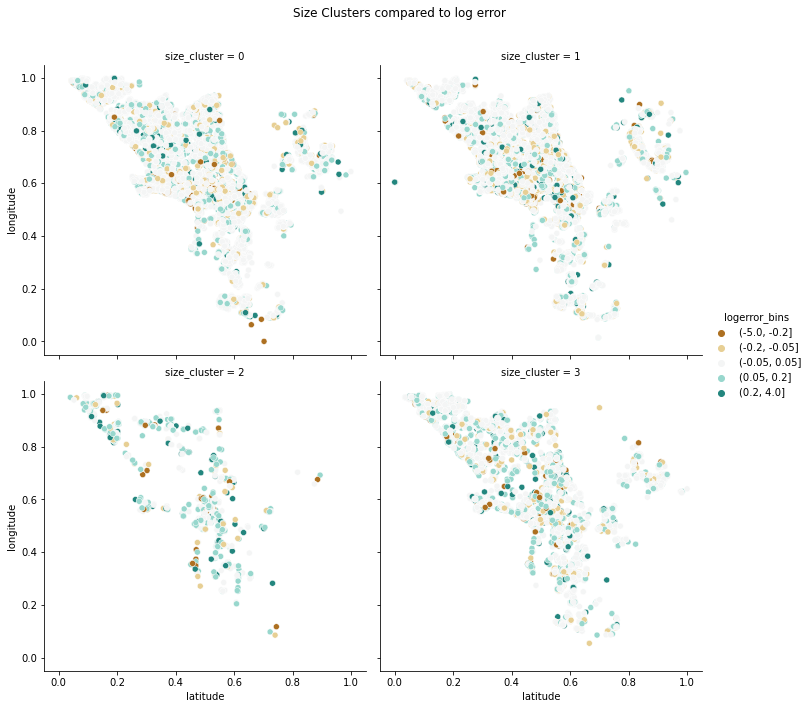

In [45]:
g=sns.relplot(data=train_scaled, 
            x='latitude', 
            y='longitude', 
            hue='logerror_bins', 
            palette='BrBG',
            col='size_cluster', 
            col_wrap=2)
# adjust the top to fit the title
g.fig.subplots_adjust(top=0.9)
# give it a title
g.fig.suptitle('Size Clusters compared to log error')
plt.show()

In [21]:
#Make Value cluster
value = train_scaled[['tax_value','structure_dollar_per_sqft']]

In [22]:
#Fit and predict
kmeans = KMeans(n_clusters=4)
kmeans.fit(value)
kmeans.predict(value)

array([1, 3, 3, ..., 1, 0, 3], dtype=int32)

In [23]:
train_scaled['value_cluster'] = kmeans.predict(value)

In [24]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=value.columns)
centroids

,tax_value,structure_dollar_per_sqft
0,0.062040,0.131540
1,0.022220,0.074362
2,0.215628,0.301633
3,0.009881,0.034780


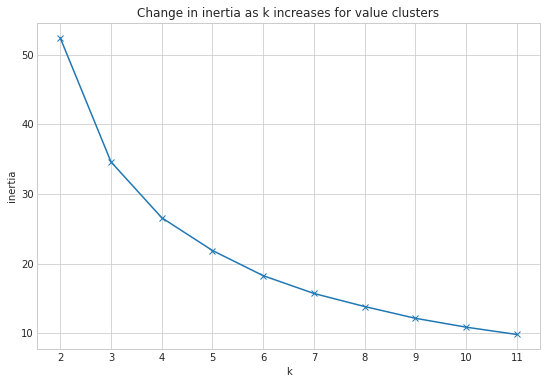

In [64]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(value).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases for value clusters')

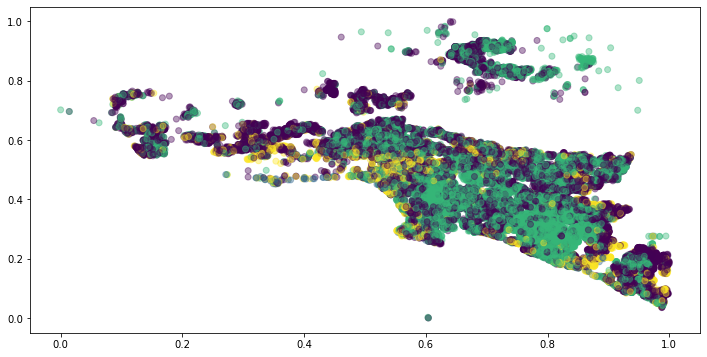

In [65]:
plt.figure(figsize=(12,6))
plt.scatter(y=train_scaled.latitude, x=train_scaled.longitude, c=train_scaled.value_cluster, alpha=.4)
#plt.scatter(y=X_train.age, x=X_train.longitude, c=X_train.area_cluster, alpha=.4)


Text(0.5, 1.0, 'Do clusters reveal differences in value and error?')

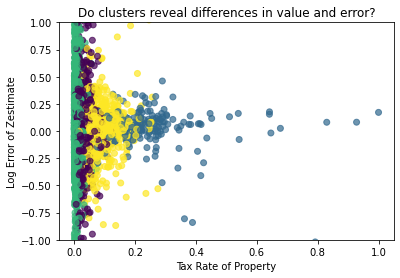

In [66]:
plt.scatter(y=train_scaled.log_error, x=train_scaled.tax_value, c=train_scaled.value_cluster, alpha=.7)
plt.ylim(-1,1)
plt.xlabel('Tax Rate of Property')
plt.ylabel('Log Error of Zestimate')
plt.title("Do clusters reveal differences in value and error?")

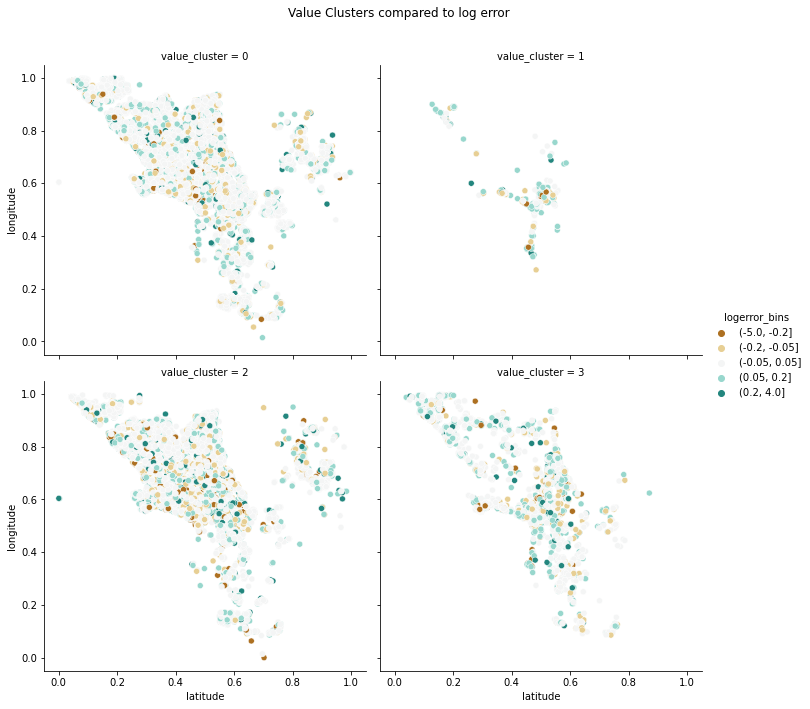

In [67]:
g=sns.relplot(data=train_scaled, 
            x='latitude', 
            y='longitude', 
            hue='logerror_bins', 
            palette='BrBG',
            col='value_cluster', 
            col_wrap=2)
# adjust the top to fit the title
g.fig.subplots_adjust(top=0.9)
# give it a title
g.fig.suptitle('Value Clusters compared to log error')
plt.show()

In [25]:
#Creating dummy variables from location cluster
dummy_1 = pd.get_dummies(train_scaled.location_cluster, columns=['loc_0','loc_1','loc_2','loc_3'])
# Concat these back onto df
train_scaled = pd.concat([train_scaled, dummy_1], axis=1)
#Rename clustered variables
train_scaled.rename(columns = {0:'loc_0',1:'loc_1',2:'loc_2',3:'loc_3'}, inplace = True)

In [29]:
#Creating dummy variables from size cluster
dummy_2 = pd.get_dummies(train_scaled.size_cluster, columns=['size_0', 'size_1', 'size_2', 'size_3'])
# Concat these back onto df
train_scaled = pd.concat([train_scaled, dummy_2], axis=1)
#Rename clustered variables
train_scaled.rename(columns = {0:'size_0',1:'size_1',2:'size_2',3:'size_3'}, inplace = True)

In [31]:
#Creating dummy variables from value cluster
dummy_3 = pd.get_dummies(train_scaled.value_cluster, columns=['value_0','value_1','value_2','value_3'])
# Concat these back onto df
train_scaled = pd.concat([train_scaled, dummy_3], axis=1)
#Rename clustered variables
train_scaled.rename(columns = {0:'value_0',1:'value_1',2:'value_2',3:'value_3'}, inplace = True)

In [32]:
train_scaled.head().T

,38935,31408,30966,5412,45802
parcel_id,14392368,14368210,11300975,13926000,17229160
propertylandusetypeid,261.0,261.0,261.0,261.0,261.0
basement_sqft,0.0,0.0,0.0,0.0,0.0
bath_count,2.5,2.5,3.0,2.0,2.5
bed_count,4.0,4.0,3.0,3.0,3.0
...,...,...,...,...,...
size_3,0,1,1,0,0
value_0,0,0,0,0,0
value_1,1,0,0,0,1
value_2,0,0,0,0,0


In [10]:
def make_clusters(train,validate,test):
    #scale the data
    train_scaled, validate_scaled, test_scaled= scale_data(train,validate,test, columns_to_scale =
                                                       ['latitude','longitude','age','bath_bed_ratio', 'calc_sqft',
                                                       'taxrate','structure_dollar_per_sqft','tax_value'])
    #Make location cluster
    location = train_scaled[['latitude','longitude','age']]
    #Fit and predict location for k=4
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(location)
    kmeans.predict(location)
    #Add column back to train scaled for this cluster
    train_scaled['location_cluster'] = kmeans.predict(location)
    
    #Make Size cluster
    size = train_scaled[['bath_bed_ratio','calc_sqft']]
    #Fit and predict
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(size)
    kmeans.predict(size)
    #Add column back to train scaled for this cluster
    train_scaled['size_cluster'] = kmeans.predict(size)
    
    #Make value cluster
    value = train_scaled[['tax_value','structure_dollar_per_sqft']]
    #Fit and predict
    kmeans = KMeans(n_clusters=4)
    kmeans.fit(value)
    kmeans.predict(value)
    #Add column back to train scaled for this cluster
    train_scaled['value_cluster'] = kmeans.predict(value)
    
    #Creating dummy variables from location cluster
    dummy_1 = pd.get_dummies(train_scaled.location_cluster, columns=['loc_0','loc_1','loc_2','loc_3'])
    # Concat these back onto df
    train_scaled = pd.concat([train_scaled, dummy_1], axis=1)
    #Rename clustered variables
    train_scaled.rename(columns = {0:'loc_0',1:'loc_1',2:'loc_2',3:'loc_3'}, inplace = True)
    
    #Creating dummy variables from size cluster
    dummy_2 = pd.get_dummies(train_scaled.size_cluster, columns=['size_0', 'size_1', 'size_2', 'size_3'])
    # Concat these back onto df
    train_scaled = pd.concat([train_scaled, dummy_2], axis=1)
    #Rename clustered variables
    train_scaled.rename(columns = {0:'size_0',1:'size_1',2:'size_2',3:'size_3'}, inplace = True)
    
    #Creating dummy variables from value cluster
    dummy_3 = pd.get_dummies(train_scaled.value_cluster, columns=['value_0','value_1','value_2','value_3'])
    # Concat these back onto df
    train_scaled = pd.concat([train_scaled, dummy_3], axis=1)
    #Rename clustered variables
    train_scaled.rename(columns = {0:'value_0',1:'value_1',2:'value_2',3:'value_3'}, inplace = True)
    
    return train_scaled, validate_scaled, test_scaled

In [8]:
train_scaled, validate_scaled, test_scaled = m.make_clusters(train,validate,test)

In [9]:
train_scaled.head().T

,38935,31408,30966,5412,45802
parcel_id,14392368,14368210,11300975,13926000,17229160
propertylandusetypeid,261.0,261.0,261.0,261.0,261.0
basement_sqft,0.0,0.0,0.0,0.0,0.0
bath_count,2.5,2.5,3.0,2.0,2.5
bed_count,4.0,4.0,3.0,3.0,3.0
calc_bath_and_bed,2.5,2.5,3.0,2.0,2.5
decktypeid,0.0,0.0,0.0,0.0,0.0
calc_sqft,0.228513,0.179314,0.12031,0.11042,0.107691
finished_sqft12,2832.0,2255.0,1563.0,1447.0,1415.0
fips,6059.0,6059.0,6037.0,6059.0,6111.0
